In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached fortitudo_tech-1.1.12-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached protobuf-6.33.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.ma

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import yfinance as yf
from cvxopt import matrix, solvers
from copy import copy
from time import time

In [34]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    # Active tech stocks
    'AAPL', 'MSFT', 'NVDA', 'AMD', 'INTC', 'CSCO', 'ORCL', 'IBM', 'ADBE', 'CRM', 
    'NOW', 'INTU', 'AMAT', 'LRCX', 'KLAC', 'MCHP', 'TXN', 'ADI', 'QCOM', 'AVGO',
    'NXPI', 'MU', 'STX', 'WDC', 'HPQ', 'HPE', 'DELL', 'ANET', 'FFIV', 'JNPR',
    'CTSH', 'IT', 'ACN', 'EPAM', 'FTNT', 'PANW', 'CRWD', 'SNPS', 'CDNS', 'ANSS',
    'KEYS', 'TER', 'IPGP', 'GLW', 'APH', 'TEL', 'AKAM', 'ADSK', 'CIEN', 'SMCI',
    'APP', 'DDOG', 'PLTR', 'FICO', 'GEN', 'BR', 'JKHY', 'FIS', 'FI', 'CSGP',
    'TYL', 'MPWR', 'ON', 'SWKS'
]

# Removed (delisted/acquired):
# MXIM - acquired by ADI (2021)
# XLNX - acquired by AMD (2022)
# ALTR - acquired by Intel (2015)
# LLTC - acquired by ADI (2017)
# BRCM - acquired by Avago/Broadcom (2016)
# CA - acquired by Broadcom (2018)
# EMC - acquired by Dell (2016)
# NVLS - acquired by Lam Research (2012)
# LSI - acquired by Avago (2014)  

data = data[[t for t in selected_assets if t in data.columns]]

data_clean = data.dropna(axis=1, how='any')
vix_raw = yf.download('^VIX', start=data_clean.index[0], end=data_clean.index[-1], progress=False)
vix = vix_raw['Close']['^VIX'] if isinstance(vix_raw.columns, pd.MultiIndex) else vix_raw['Close']
vix = vix.reindex(data_clean.index).ffill().dropna()
common_dates = data_clean.index.intersection(vix.index)
asset_data = data_clean.loc[common_dates]
vix = vix.loc[common_dates]
pnl = np.log(asset_data / asset_data.shift(1)).dropna()

print(f"Assets: {asset_data.shape[1]} | Days: {len(asset_data)} | Range: {asset_data.index[0].date()} to {asset_data.index[-1].date()}")
print(f"{np.round(len(pnl) / 252, 2)} years of daily data.")

Assets: 56 | Days: 2471 | Range: 2016-01-04 to 2025-11-11
9.8 years of daily data.


/tmp/ipykernel_473/1753174072.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=data_clean.index[0], end=data_clean.index[-1], progress=False)


In [35]:
 # print(data.columns.tolist())

In [36]:
stats = ft.simulation_moments(pnl.values * 100)
stats.index = pnl.columns
stats.head(10)

,Mean,Volatility,Skewness,Kurtosis
AAPL,0.099194,1.841499,-0.099129,9.575050
MSFT,0.095504,1.690864,-0.163114,10.936006
NVDA,0.222657,3.142065,0.082826,9.573859
AMD,0.180219,3.667451,0.617653,13.557663
INTC,0.013903,2.537773,-0.617881,19.616091
CSCO,0.052618,1.589060,-0.696841,15.183791
ORCL,0.082376,2.013661,1.548119,35.692002
IBM,0.051098,1.582225,-0.463420,14.438937
ADBE,0.052119,2.149297,-0.771259,13.162755
CRM,0.047360,2.210965,-0.263478,16.176776


In [37]:
vix_aligned = vix.loc[pnl.index].values

imp_vol_25pct = np.percentile(vix_aligned, 25)
imp_vol_90pct = np.percentile(vix_aligned, 90)

low_vol_indices = vix_aligned <= imp_vol_25pct
mid_vol_indices = (vix_aligned > imp_vol_25pct) & (vix_aligned <= imp_vol_90pct)
high_vol_indices = vix_aligned > imp_vol_90pct

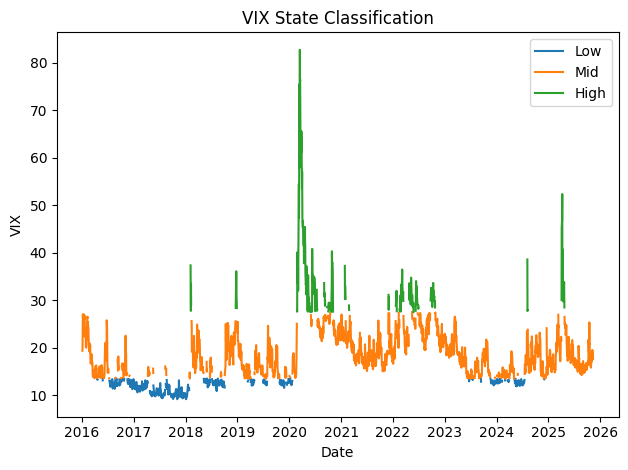

In [38]:
vol_low = np.ma.masked_where(~low_vol_indices, vix_aligned)
vol_mid = np.ma.masked_where(~mid_vol_indices, vix_aligned)
vol_high = np.ma.masked_where(~high_vol_indices, vix_aligned)

plt.plot(pnl.index, vol_low, label='Low')
plt.plot(pnl.index, vol_mid, label='Mid')
plt.plot(pnl.index, vol_high, label='High')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.title('VIX State Classification')
plt.tight_layout()
plt.show()

In [39]:
T_tilde = len(pnl)
I = pnl.shape[1]
log_returns = pnl.values

p_exp = ft.exp_decay_probs(log_returns, half_life=T_tilde / 2)

mu_low = np.mean(vix_aligned[low_vol_indices])
sigma_low = np.std(vix_aligned[low_vol_indices])
mu_mid = np.mean(vix_aligned[mid_vol_indices])
sigma_mid = np.std(vix_aligned[mid_vol_indices])
mu_high = np.mean(vix_aligned[high_vol_indices])
sigma_high = np.std(vix_aligned[high_vol_indices])

A = np.vstack((np.ones((1, T_tilde)), vix_aligned[np.newaxis, :]))
b_low = np.array([[1.], [mu_low]])
b_mid = np.array([[1.], [mu_mid]])
b_high = np.array([[1.], [mu_high]])

G = vix_aligned[np.newaxis, :] ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
states_vector = 0 * low_vol_indices.astype(int) + 1 * mid_vol_indices.astype(int) + 2 * high_vol_indices.astype(int)

S = 10000
H = 21
np.random.seed(1)

sim_indices = resampling(S, H, states_vector[-1], states_prob, states_vector)
return_sim_1m = np.exp(np.cumsum(log_returns[sim_indices], axis=1))[:, -1, :] - 1

print(f"Simulations: {S} | Horizon: {H} days | Assets: {I}")
print(f"Return simulation shape: {return_sim_1m.shape}")
print(f"Current regime: {'Low' if states_vector[-1] == 0 else 'Mid' if states_vector[-1] == 1 else 'High'}")

Simulations: 10000 | Horizon: 21 days | Assets: 56
Return simulation shape: (10000, 56)
Current regime: Mid


In [40]:
stats_sim = ft.simulation_moments(100 * return_sim_1m)
stats_sim.index = pnl.columns
stats_sim.head(10)

,Mean,Volatility,Skewness,Kurtosis
AAPL,3.195578,7.960926,-0.012803,3.902358
MSFT,3.168825,7.089867,-0.002277,3.820545
NVDA,7.434264,14.992976,0.396699,3.740728
AMD,6.419210,17.178625,0.577672,4.355690
INTC,1.918938,11.943187,0.191642,4.029977
CSCO,2.127530,6.393390,-0.167219,4.118314
ORCL,3.141990,10.123451,0.826045,6.316607
IBM,2.339371,6.710438,-0.033070,4.274894
ADBE,2.318236,9.725125,0.049663,3.552525
CRM,2.273314,9.712937,0.138988,3.980409


In [41]:
G = -np.eye(I)
h = np.zeros(I)

cvar_opt = ft.MeanCVaR(return_sim_1m, G, h)

print(f"Optimizer initialized | Assets: {I} | Simulations: {return_sim_1m.shape[0]}")

Optimizer initialized | Assets: 56 | Simulations: 10000


In [42]:
return_target = np.mean(np.mean(return_sim_1m, axis=0))

start_time = time()
e_opt_prior = cvar_opt.efficient_portfolio(return_target)
print(f"Prior CVaR efficient portfolio | S={S} scenarios | I={I} assets | Time: {np.round(time() - start_time, 2)}s")

Prior CVaR efficient portfolio | S=10000 scenarios | I=56 assets | Time: 11.25s


In [43]:
# Verify prior results
tol = 1e-10  # tolerance for numerical deviations from bounds
assert np.abs(np.sum(e_opt_prior) - 1) <= tol  # sum to 1
assert np.all(e_opt_prior >= 0 - tol)  # long-only
assert np.abs(np.mean(return_sim_1m @ e_opt_prior) - return_target) <= tol  # return target

In [44]:
view_col = 'AAPL'
view_idx = pnl.columns.get_loc(view_col)
view_multiplier = 1.0  # This a mean view

A_ep = np.vstack((np.ones((1, S)), return_sim_1m[:, view_idx][np.newaxis, :]))
b_ep = np.array([[1], [np.mean(return_sim_1m[:, view_idx]) * view_multiplier]])
q = ft.entropy_pooling(np.ones((S, 1)) / S, A_ep, b_ep)

print(f"View on: {view_col} (index {view_idx}) | Target: {(view_multiplier - 1) * 100:+.0f}% relative change in expected return")

View on: AAPL (index 0) | Target: +0% relative change in expected return


In [45]:
cvar_opt_post = ft.MeanCVaR(return_sim_1m, G, h, p=q)
return_target_post = np.mean(q.T @ return_sim_1m)

start_time = time()
e_opt_post = cvar_opt_post.efficient_portfolio(return_target_post)
print(f"Posterior CVaR efficient portfolio | S={S} scenarios | I={I} assets | Time: {np.round(time() - start_time, 2)}s")

Posterior CVaR efficient portfolio | S=10000 scenarios | I=56 assets | Time: 11.5s


In [46]:
# Verify posterior results
assert np.abs(np.sum(e_opt_post) - 1) <= tol  # sum to 1
assert np.all(e_opt_post >= 0 - tol)  # long-only
assert np.abs(q.T @ return_sim_1m @ e_opt_post - return_target_post) <= tol  # return target

In [47]:
exposures = pd.DataFrame({
    'Prior': e_opt_prior.flatten() * 100,
    'Posterior': e_opt_post.flatten() * 100,
    'Difference': (e_opt_post - e_opt_prior).flatten() * 100
}, index=pnl.columns)

exposures = exposures.sort_values('Posterior', ascending=False)
exposures[exposures['Posterior'] > 0.1]

,Prior,Posterior,Difference
BR,18.778603,18.778603,1.874159e-07
IBM,17.646834,17.646834,-4.101927e-08
APH,10.783020,10.783020,-4.592739e-07
MSFT,10.422133,10.422133,4.237633e-07
JKHY,8.724185,8.724185,2.513591e-08
AVGO,7.365642,7.365642,-6.759794e-08
ORCL,5.913776,5.913776,1.692465e-07
STX,5.645376,5.645376,-1.478986e-07
PANW,4.815775,4.815775,9.789017e-08
TYL,3.917133,3.917133,-3.844058e-08


In [48]:
prior_ret = return_sim_1m.mean(axis=0) @ e_opt_prior.flatten()
posterior_ret = (q.T @ return_sim_1m).flatten() @ e_opt_post.flatten()

print(f"Expected 1M Return | Prior: {prior_ret * 100:.2f}% | Posterior: {posterior_ret * 100:.2f}%")
print(f"Annualized Return  | Prior: {prior_ret * 12 * 100:.2f}% | Posterior: {posterior_ret * 12 * 100:.2f}%")

Expected 1M Return | Prior: 3.04% | Posterior: 3.04%
Annualized Return  | Prior: 36.45% | Posterior: 36.45%


In [49]:
prior_tickers = exposures[exposures['Prior'] > 0.5].index.tolist()
posterior_tickers = exposures[exposures['Posterior'] > 0.5].index.tolist()

print(f"Prior tickers ({len(prior_tickers)}): {prior_tickers}")
print(f"Posterior tickers ({len(posterior_tickers)}): {posterior_tickers}")

Prior tickers (13): ['BR', 'IBM', 'APH', 'MSFT', 'JKHY', 'AVGO', 'ORCL', 'STX', 'PANW', 'TYL', 'FICO', 'NVDA', 'GEN']
Posterior tickers (13): ['BR', 'IBM', 'APH', 'MSFT', 'JKHY', 'AVGO', 'ORCL', 'STX', 'PANW', 'TYL', 'FICO', 'NVDA', 'GEN']
